In [1]:
# !pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   --- ------------------------------------ 12.1/124.9 MB 53.9 MB/s eta 0:00:03
   -------- ------------------------------- 25.2/124.9 MB 59.0 MB/s eta 0:00:02
   ----------- ---------------------------- 35.9/124.9 MB 55.6 MB/s eta 0:00:02
   --------------- ------------------------ 46.9/124.9 MB 55.3 MB/s eta 0:00:02
   ---------------- ----------------------- 51.6/124.9 MB 49.1 MB/s eta 0:00:02
   ----------------- ---------------------- 56.1/124.9 MB 44.1 MB/s eta 0:00:02
   --------------------- ------------------ 66.3/124.9 MB 44.5 MB/s eta 0:00:02
   ------------------------- -------------- 78.9/124.9 MB 46.6 MB/s eta 0:00:01
   -------------------------- ------------- 82.6/124.9 MB 43.2 MB/s eta 0:00:01
   ------------------------------ --------- 94.9/124.9 MB 44.9 MB/s eta 0:00:01
   --------------------------------- ----- 108.0/124.9 MB 46.3 MB/s eta 0:00:01
   ------------------------------------- - 120.6/

In [2]:
# !pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 38.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 1. CSV 파일 불러오기
data = pd.read_csv('../Data/preprocessed_movies_data.csv')

# 2. 필요한 컬럼만 선택
features = ['grossWorldWide', 'gross_US_Canada', 'opening_weekend_Gross', 'budget', 'Rating', 
            'Votes', 'Category', 'directors', 'stars', 'production_companies']
data = data[features]

# 3. 쉼표로 구분된 값을 리스트로 분리
def split_to_list(column):
    return column.apply(lambda x: [item.strip() for item in x.split(',')])

data['directors'] = split_to_list(data['directors'])
data['stars'] = split_to_list(data['stars'])
data['production_companies'] = split_to_list(data['production_companies'])

# 4. 타겟 인코딩
categorical_features = ['Category', 'directors', 'stars', 'production_companies']
for feature in categorical_features:
    if feature in ['directors', 'stars', 'production_companies']:
        data[feature] = data[feature].apply(lambda x: ', '.join(x))
    mean_target = data.groupby(feature)['grossWorldWide'].mean()
    data[feature] = data[feature].map(mean_target)

# 5. 데이터 정규화
target_features = ['grossWorldWide', 'gross_US_Canada', 'opening_weekend_Gross', 'budget', 'Rating', 'Votes']
scaler = MinMaxScaler()
data[target_features] = scaler.fit_transform(data[target_features])

In [7]:
# 6. 흥행 기준 설정
# 예산 대비 수익이 1배 이상이면 흥행(1), 아니면 비흥행(0)
data['target'] = (data['grossWorldWide'] >= data['budget']).astype(int)

# 7. 학습 및 테스트 데이터 분리
X = data.drop(['target', 'grossWorldWide'], axis=1)  # 타겟 및 불필요 컬럼 제거
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# 9. LightGBM 모델 학습
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# 10. 예측 및 평가
xgb_pred = xgb_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))    # 정확도: 전체 데이터에서 예측이 맞은 비율
print("LightGBM Accuracy:", accuracy_score(y_test, lgbm_pred))

print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_pred))    # 정밀도, 재현율, F1-score 통해 모델 성능을 세부적으로 평가
print("\nLightGBM Classification Report:\n", classification_report(y_test, lgbm_pred))

[LightGBM] [Info] Number of positive: 6378, number of negative: 2182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1868
[LightGBM] [Info] Number of data points in the train set: 8560, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745093 -> initscore=1.072613
[LightGBM] [Info] Start training from score 1.072613
XGBoost Accuracy: 0.9929906542056075
LightGBM Accuracy: 0.9948598130841122

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       530
           1       1.00      0.99      1.00      1610

    accuracy                           0.99      2140
   macro avg       0.99      0.99      0.99      2140
weighted avg       0.99      0.99      0.99      2140


LightGBM Classification Report:
               precision    recall  f1-score

## 결과

#### 1. 모델 성능
- 정확도 (Accuracy):
    - XGBoost: 99.30%
    - LightGBM: 99.49%
    - → 두 모델 모두 매우 높은 정확도를 기록하였으며, LightGBM이 약간 더 높은 성능을 보임


- 정밀도 (Precision), 재현율 (Recall), F1-score: 클래스 0(비흥행)과 클래스 1(흥행) 모두 0.98 이상
    - 클래스 1(흥행)의 경우 정밀도, 재현율, F1-score가 거의 완벽에 가까운 값 → 이는 모델이 흥행 여부를 매우 잘 예측하고 있음을 보여줌

#### 2. 데이터 불균형
- 클래스 분포:
    - 클래스 1(흥행): 6378개 (약 74.5%)
    - 클래스 0(비흥행): 2182개 (약 25.5%)

----
## 특성 중요도 분석
- 어떤 특성이 LightGBM 모델 성능에 가장 큰 영향을 미쳤는 지 파악하기 위함 -> 전략 수립 및 데이터 수집 방향 설정

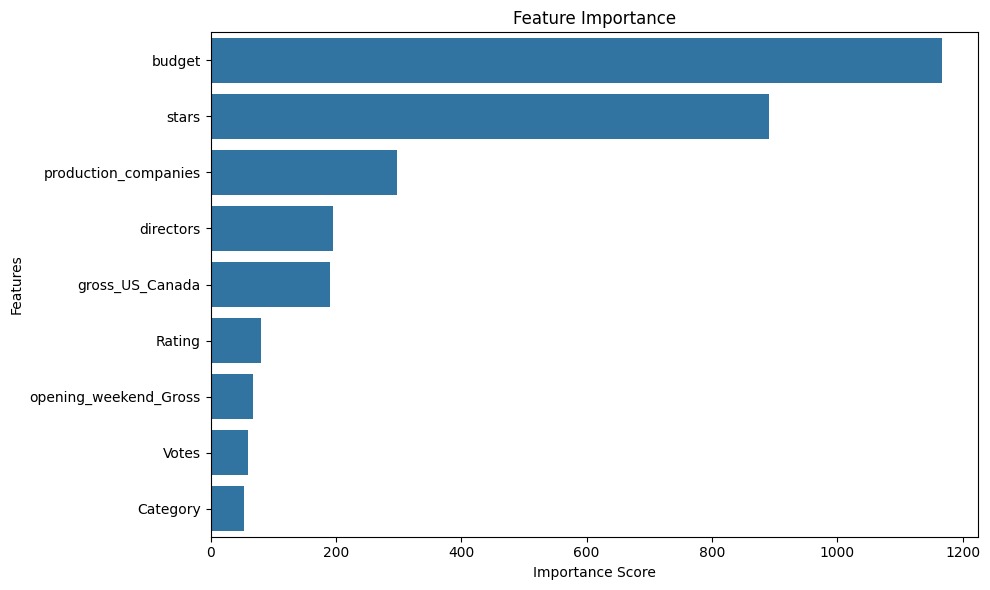

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 특성 중요도 가져오기
feature_importances = lgbm_model.feature_importances_
feature_names = X.columns

# 데이터프레임으로 정리
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

#### 결과
- 모델 성능에 큰 영향을 미치는 것: 
    - budget(예산)이 가장 중요한 특성 > stars(출연 배우) > production_companies(제작사) 
- 흥행을 좌우하는 주요 요인:
    - budget (예산): 높은 예산이 더 큰 스케일의 영화 제작, 유명 배우 섭외, 대규모 마케팅 등을 가능하게 하기 때문
    - stars (출연 배우): 유명 배우들이 영화의 대중성을 높이고 더 많은 관객을 끌어들이는 효과를 발휘하기 때문
    - production_companies (제작사): 영화의 품질과 홍보 역량에 영향을 미치는 주요 요소로, 성공적인 제작사와 협업할수록 흥행 가능성이 높아지는 경향이 있을 수 있음
- 두 번째 요인:
    - 감독(directors)과 북미 수익(gross_US_Canada): 특정 감독의 브랜드 파워와 북미 시장에서의 초기 성공이 영화 전체 흥행에 중요한 지표가 될 수 있음을 보여줌
- 상대적으로 덜 중요한 요인:
    - 영화의 개봉 첫 주 수익(opening_weekend_Gross)와 평가 점수(Rating)는 상대적으로 덜 중요한 것으로 보임. 
    - -> 이는 초기 흥행보다 장기적인 흥행이 전체적인 성공을 더 잘 설명할 수 있음을 나타냄.

----
### 데이터 불균형 문제 - 앙상블 기법 (Balanced Random Forest)
**데이터 불균형 문제 해결**:
 - 영화 흥행 여부(0/1)가 불균형 데이터를 가지므로, BRF는 소수 클래스를 과소평가하지 않고 균형 잡힌 학습이 가능합니다.
 - 결과적으로, 소수 클래스(흥행 실패)의 Recall이 높아졌고, 이는 예측 신뢰도를 높이는 데 기여했습니다.


In [10]:
# !pip install imbalanced-learn

In [11]:
from imblearn.ensemble import BalancedRandomForestClassifier

# 균형 랜덤 포레스트 학습
brf_model = BalancedRandomForestClassifier(random_state=42)
brf_model.fit(X_train, y_train)
y_pred_brf = brf_model.predict(X_test)

print("Balanced Random Forest Accuracy:", accuracy_score(y_test, y_pred_brf))
print("\nClassification Report with Balanced Random Forest:\n", classification_report(y_test, y_pred_brf))


Balanced Random Forest Accuracy: 0.9897196261682243

Classification Report with Balanced Random Forest:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       530
           1       1.00      0.99      0.99      1610

    accuracy                           0.99      2140
   macro avg       0.98      0.99      0.99      2140
weighted avg       0.99      0.99      0.99      2140



#### **최종 결론**
1. **주요 요인 분석**:
 - 흥행 예측에 가장 중요한 요인은 `budget`(예산), `stars`(배우), `production_companies`(제작사)

2. **최종 인사이트**:
 - 예산(`budget`)과 배우(`stars`)를 중심으로 투자 전략을 최적화하면, 흥행 가능성을 높일 수 있음.
 - 실패 가능성이 높은 프로젝트를 사전에 식별하여 리스크를 줄일 수 있습니다.
